In [1]:
# library import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

2024-12-09 13:23:45.648923: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 13:23:46.399838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 13:23:46.401732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 13:23:46.585350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 13:23:46.896903: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#import data and view shape and first 5 lines
game_reviews = pd.read_csv("reviews_dataset.csv")
print(game_reviews.shape)
game_reviews.head()

(6417106, 5)


,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [3]:
game_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [4]:
game_reviews = game_reviews.drop("app_id", axis=1)
game_reviews = game_reviews.drop("app_name", axis=1)
game_reviews = game_reviews.drop("review_votes", axis=1)
game_reviews = game_reviews.dropna(how='any',axis=0)
game_reviews["review_score"].value_counts()

review_score
 1    5254116
-1    1155685
Name: count, dtype: int64

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X = vectorizer.fit_transform(game_reviews["review_text"])
print(X)

X_train, X_test, y_train, y_test = train_test_split(X, game_reviews['review_score'], test_size=0.3,
                                                    stratify=game_reviews['review_score'], random_state=0)

In [ ]:
model = LinearSVC(random_state=0, tol=1e-5)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_pred, y_test))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(game_reviews["review_text"]), pd.DataFrame(game_reviews['review_score']))
X = vectorizer.fit_transform(X_resampled["review_text"])

X_train, X_test, y_train, y_test = train_test_split(X, y_resampled['review_score'], test_size=0.3,
                                                    stratify=y_resampled['review_score'], random_state=0)

In [ ]:
model = LinearSVC(random_state=0, tol=1e-5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_pred, y_test))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(game_reviews["review_text"]), pd.DataFrame(game_reviews['review_score']))

resampled = pd.DataFrame()
resampled['review_text'] = X_resampled['review_text']
resampled['review_score'] = y_resampled['review_score']

resampled['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in resampled['review_text']]

porter_stemmer = PorterStemmer()
resampled['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in resampled['tokenized_text'] ]

resampled = resampled[resampled.stemmed_tokens.str.len() > 0]

w2v_model = Word2Vec(resampled["stemmed_tokens"], min_count=1, vector_size=100, window=5)

In [ ]:
review_vectors = []
for row in resampled["stemmed_tokens"]:
    review_vectors.append(w2v_model.wv.get_mean_vector(row))
review_vectors_df = pd.DataFrame(review_vectors)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(review_vectors_df[:], resampled['review_score'], test_size=0.3,
                                                    stratify=resampled['review_score'], random_state=0)
model = LinearSVC(random_state=0, tol=1e-5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_pred, y_test))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
game_reviews['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in game_reviews['review_text']]

porter_stemmer = PorterStemmer()
game_reviews['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in game_reviews['tokenized_text'] ]

game_reviews = game_reviews[game_reviews.stemmed_tokens.str.len() > 0]

w2v_model = Word2Vec(game_reviews["stemmed_tokens"], min_count=1, vector_size=100, window=5)

In [ ]:
review_vectors = []
for row in game_reviews["stemmed_tokens"]:
    review_vectors.append(w2v_model.wv.get_mean_vector(row))
review_vectors_df = pd.DataFrame(review_vectors)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(review_vectors_df[:], game_reviews['review_score'], test_size=0.3,
                                                    stratify=game_reviews['review_score'], random_state=0)
model = LinearSVC(random_state=0, tol=1e-5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_pred, y_test))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [6]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(game_reviews["review_text"]), pd.DataFrame(game_reviews['review_score']))

resampled = pd.DataFrame()
resampled['review_text'] = X_resampled['review_text']
resampled['review_score'] = y_resampled['review_score']

resampled['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in resampled['review_text']]

porter_stemmer = PorterStemmer()
resampled['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in resampled['tokenized_text'] ]

resampled = resampled[resampled.stemmed_tokens.str.len() > 0]

w2v_model = Word2Vec(resampled["stemmed_tokens"], min_count=1, vector_size=100, window=5)

review_vectors = []
for row in resampled["stemmed_tokens"]:
    review_vectors.append(w2v_model.wv.get_mean_vector(row))
review_vectors_df = pd.DataFrame(review_vectors)

ValueError: Found input variables with inconsistent numbers of samples: [2297605, 6409801]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(review_vectors_df[:], resampled['review_score'], test_size=0.3,
                                                    stratify=resampled['review_score'], random_state=0)

Epoch 1/15
25131/25131 [==============================] - 72s 3ms/step - loss: -1278996736.0000 - accuracy: 0.0466 - val_loss: -5485935616.0000 - val_accuracy: 0.0470
Epoch 2/15
25131/25131 [==============================] - 70s 3ms/step - loss: -25485205504.0000 - accuracy: 0.0472 - val_loss: -59787849728.0000 - val_accuracy: 0.0464
Epoch 3/15
25131/25131 [==============================] - 70s 3ms/step - loss: -141384253440.0000 - accuracy: 0.0468 - val_loss: -256319700992.0000 - val_accuracy: 0.0465
Epoch 4/15
25131/25131 [==============================] - 70s 3ms/step - loss: -465421205504.0000 - accuracy: 0.0469 - val_loss: -733322149888.0000 - val_accuracy: 0.0467
Epoch 5/15
25131/25131 [==============================] - 70s 3ms/step - loss: -1161997713408.0000 - accuracy: 0.0471 - val_loss: -1677372293120.0000 - val_accuracy: 0.0466
Epoch 6/15
25131/25131 [==============================] - 70s 3ms/step - loss: -2437774835712.0000 - accuracy: 0.0469 - val_loss: -3320308039680.0000

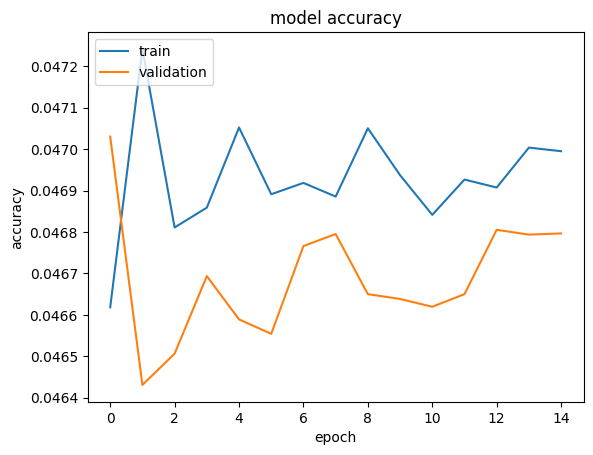

NameError: name 'model' is not defined

In [16]:
cnn_model = Sequential()
cnn_model.add(Dense(50, activation = "linear"))
cnn_model.add(Dropout(0.3, noise_shape=None, seed=None))
cnn_model.add(Dense(50, activation = "linear"))
cnn_model.add(Dropout(0.2, noise_shape=None, seed=None))
cnn_model.add(Dense(50, activation = "linear"))
cnn_model.add(Dense(1, activation = "sigmoid"))

cnn_model.compile(loss="binary_crossentropy",
                optimizer='adam',
                metrics=['accuracy'])
history = cnn_model.fit(X_train, y_train, 64,
                    epochs= 15,
                    validation_data= (X_test, y_test))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

scores = cnn_model.evaluate(test_x, test_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))